In [1]:
from src.data_loader import DataLoader
from src.sales_processor import SalesProcessor
from src.feature_engineer import FeatureEngineer
from src.data_aggregator import DataAggregator
import pandas as pd


In [2]:
data_loader = DataLoader()
# data_dict = data_loader.load_all_data()
customer_master = data_loader.load_customer_master()
sales_data = data_loader.load_sales_data()

sales_processor = SalesProcessor(sales_data, customer_master)
sales_results = sales_processor.process_sales_data()

last_billed = sales_results['last_billed']
sales_journey = sales_results['sales_journey']
days_between_purchase = sales_results['days_between_purchase']


print(f"✅ Sales data processed successfully:")
print(f"   - Last Billed: {last_billed.shape}")
print(f"   - Sales Journey: {sales_journey.shape}")
print(f"   - Days Between Purchase: {days_between_purchase.shape}")


        

⚡ Initializing Databricks Spark session...
✅ Session initialized successfully.
📁 Setting catalog to: `provisioned-tableau-data`
📄 Setting schema to: `tableau_delta_tables`
⚡ Initializing Databricks Spark session...
✅ Session initialized successfully.
📁 Setting catalog to: `provisioned-tableau-data`
📄 Setting schema to: `sap_data`
⚡ Initializing Databricks Spark session...
✅ Session initialized successfully.
📁 Setting catalog to: `provisioned-tableau-data`
📄 Setting schema to: `jkc`
📖 Reading table: `customer_master`...
✅ Successfully read data from `customer_master`.
📖 Reading table: `sales_data`...
✅ Successfully read data from `sales_data`.
Preparing sales data...
Calculating churn labels...
Calculating sales streaks...


/Users/sanyamjain/Desktop/work/dealer-churn-1/src/sales_processor.py:89: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  streak_info_df = full_sales.groupby('dealer_code').apply(self._get_max_streak_info).reset_index()


Calculating threshold dates...
Creating sales journey...
Calculating days between purchases...
✅ Sales data processed successfully:
   - Last Billed: (7791, 8)
   - Sales Journey: (4686430, 37)
   - Days Between Purchase: (7717, 2)


In [3]:
print("\n🔧 Step 3: Feature Engineering")
print("-" * 30)
feature_engineer = FeatureEngineer(sales_journey, customer_master, sales_processor.reference_date)

# Add dealership age
customer_master = feature_engineer.add_dealership_age()

# Create monthly sales features
monthly_sales = feature_engineer.create_monthly_sales_features()

# Create territory and club features
terrwise_monthly_sales, dealerclubwise_monthly_sales = feature_engineer.create_territory_and_club_features(monthly_sales)

# Merge territory and club features
monthly_sales = pd.merge(
    monthly_sales, 
    terrwise_monthly_sales, 
    on=['territory_code', 'period'], 
    how='left'
).merge(
    dealerclubwise_monthly_sales, 
    on=['dealer_club_category', 'period'], 
    how='left'
)


🔧 Step 3: Feature Engineering
------------------------------


In [4]:
sas_monthly_data = data_loader.load_sas_monthly_data()
# Process SAS data
sas_monthly_data = feature_engineer.process_sas_data(sas_monthly_data)

# Create rotation features
monthly_sales, terrwise_sas, dealerclub_wise_sas = feature_engineer.create_rotation_features(
    monthly_sales, sas_monthly_data
)

# Merge SAS features
monthly_sales = pd.merge(
    monthly_sales, 
    terrwise_sas, 
    on=['territory_code', 'period'], 
    how='left'
).merge(
    dealerclub_wise_sas, 
    on=['dealer_club_category', 'period'], 
    how='left'
)

📖 Reading table: `monthly_club_mapping`...
✅ Successfully read data from `monthly_club_mapping`.


In [5]:
credit_note_df = data_loader.load_credit_note_data()

📖 Reading table: `credit_note`...
✅ Successfully read data from `credit_note`.


In [6]:
movement_counts = feature_engineer.create_club_movement_features(sas_monthly_data)

outstanding_df = data_loader.load_outstanding_data()


📖 Reading table: `customer_financial`...
✅ Successfully read data from `customer_financial`.


In [7]:
# Process outstanding data
outstanding_df = feature_engineer.process_outstanding_data(outstanding_df)
# Create credit note features
monthly_credit_note = feature_engineer.create_credit_note_features(credit_note_df)


In [8]:
orders_df = data_loader.load_orders_data()

📖 Reading table: `orders`...
✅ Successfully read data from `orders`.


In [9]:
claims_data = data_loader.load_claims_data()

📖 Reading table: `claims_data`...
✅ Successfully read data from `claims_data`.


In [10]:
visits_data = data_loader.load_visits_data()

📖 Reading table: `visits_flat`...
✅ Successfully read data from `visits_flat`.


In [11]:

# Create order type features
order_types = feature_engineer.create_order_type_features(sales_data, orders_df)

# Create claims features
claim_count = feature_engineer.create_claims_features(claims_data)

# Create visit features
visit_count = feature_engineer.create_visit_features(visits_data)

# Create CM labels
monthly_sales = feature_engineer.create_cm_labels(monthly_sales)

print(f"✅ Features engineered successfully:")
print(f"   - Monthly Sales Features: {monthly_sales.shape}")
print(f"   - Movement Counts: {movement_counts.shape}")
print(f"   - Outstanding Data: {outstanding_df.shape}")
print(f"   - Credit Note Features: {monthly_credit_note.shape}")
print(f"   - Order Type Features: {order_types.shape}")
print(f"   - Claims Features: {claim_count.shape}")
print(f"   - Visit Features: {visit_count.shape}")


✅ Features engineered successfully:
   - Monthly Sales Features: (79558, 21)
   - Movement Counts: (9093, 4)
   - Outstanding Data: (308912, 9)
   - Credit Note Features: (229076, 4)
   - Order Type Features: (248355, 5)
   - Claims Features: (163493, 5)
   - Visit Features: (116209, 3)


/Users/sanyamjain/Desktop/work/dealer-churn-1/src/feature_engineer.py:276: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_data = monthly_data.groupby('dealer_code', group_keys=False).apply(assign_cm_labels)


In [12]:

# Step 4: Data Aggregation
print("\n📈 Step 4: Data Aggregation")
print("-" * 30)

territory_master = data_loader.load_territory_master()

data_aggregator = DataAggregator()

final_data = data_aggregator.aggregate_all_data(
    monthly_sales, outstanding_df, monthly_credit_note, order_types, 
    claim_count, visit_count, days_between_purchase, movement_counts, 
    customer_master, territory_master, last_billed
)

print("\n🎉 Pipeline completed successfully!")
print(f"Final dataset shape: {final_data.shape}")
print(f"Output saved to: offset_features.csv")



📈 Step 4: Data Aggregation
------------------------------
📖 Reading table: `territory_master`...
✅ Successfully read data from `territory_master`.
Starting data aggregation process...
Merging all features...
Creating pivot features...
Creating final dataset...
⚡ Initializing Databricks Spark session for writing...
✅ Session initialized successfully.
📁 Setting catalog to: `provisioned-tableau-data`
Saving dataset to offset_features...
📝 Writing DataFrame to table: `offset_features`...
   Mode: overwrite
   Partition by: None
   Merge schema: True
🔄 Converting Pandas DataFrame to Spark DataFrame...
📄 Setting schema to: `data_science`
❌ Error writing to table `offset_features`: [DELTA_INVALID_CHARACTERS_IN_COLUMN_NAMES] Found invalid character(s) among ' ,;{}()\n\t=' in the column names of your schema.
Invalid column names: No Change.
Please use other characters and try again.
Alternatively, enable Column Mapping to keep using these characters.

JVM stacktrace:
com.databricks.sql.transac

In [1]:
from src.model_pipeline import ModelPipeline


model_pipeline = ModelPipeline()

/Users/sanyamjain/Desktop/work/dealer-churn-1/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/sanyamjain/Desktop/work/dealer-churn-1/src/data_preprocessor.py:109: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[self.target_column] = df[self.target_column].replace(target_encoding)


🚀 Starting Complete Training Pipeline

Data Preprocessing [██████------------------------] 20.0% (1/5)
   Preparing and encoding data
🚀 Starting data preprocessing pipeline...
📊 Loading data from offset_features.csv...
✅ Data loaded successfully. Shape: (7717, 396)
🔍 Filtering data for recent churners...
✅ Filtered data. Original: (7717, 396), Filtered: (6161, 396)
📈 Creating severity feature...
✅ Severity feature created
🏆 Encoding dealer club categories...
✅ Dealer club categories encoded
🌍 Encoding zone features...
✅ Zone features encoded. Added 6 zone columns
🗺️  Encoding region features...
✅ Region features encoded. Added 36 region columns
📍 Encoding territory features...
✅ Territory features encoded
🎯 Encoding target variable...
✅ Target variable encoded
🔧 Handling missing values...
✅ Missing values handled
🗑️  Removing unnecessary columns...
✅ Removed columns: ['last_billed_days', 'severity']
🎯 Preparing features and target...
✅ Features prepared. Shape: (6161, 434), Target shap

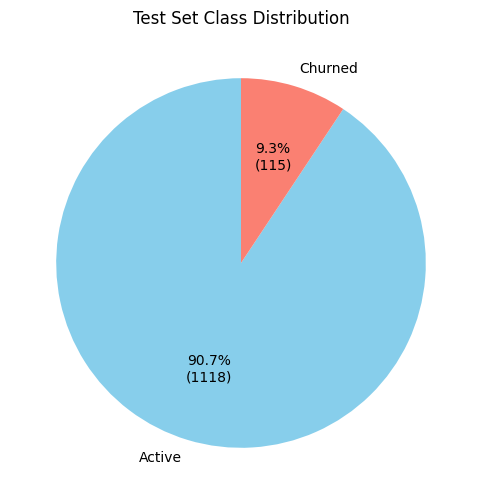

✅ Class distribution plotted
📊 Plotting confusion matrix...


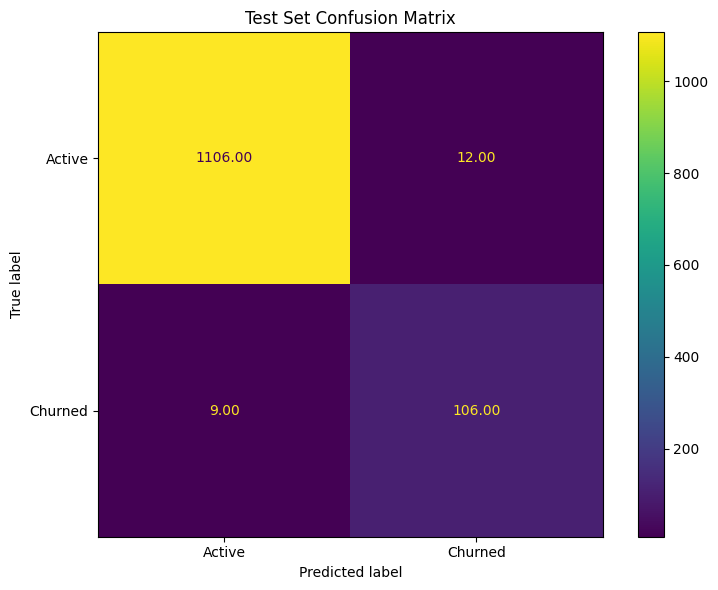

✅ Confusion matrix plotted
📊 Plotting ROC curve...


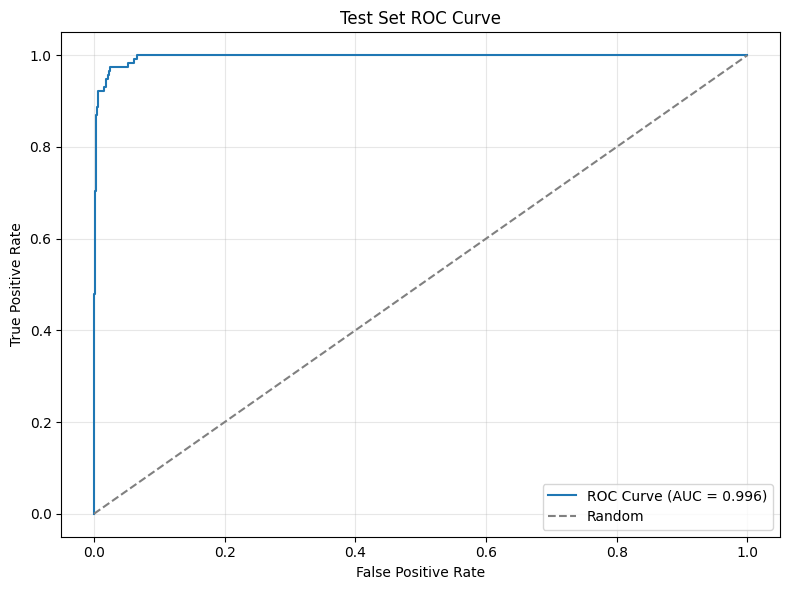

✅ ROC curve plotted
💾 Saving evaluation results to output/evaluation_results.csv...
✅ Evaluation results saved!

🎉 Model evaluation completed successfully!

Model Explanation [████████████████████████------] 80.0% (4/5)
   Generating SHAP explanations
🚀 Starting comprehensive model explanation...
🔍 Creating SHAP explainer...
✅ SHAP explainer created successfully!
🧮 Calculating SHAP values for 1233 samples...
✅ SHAP values calculated successfully!
📋 Creating explanations DataFrame...


1233it [00:00, 3212.32it/s]


✅ Explanations DataFrame created
💾 Saving explanations to output/shap_explanations.csv...
✅ Explanations saved successfully!

📊 Generating explanation plots...
📊 Plotting global feature importance (top 20)...


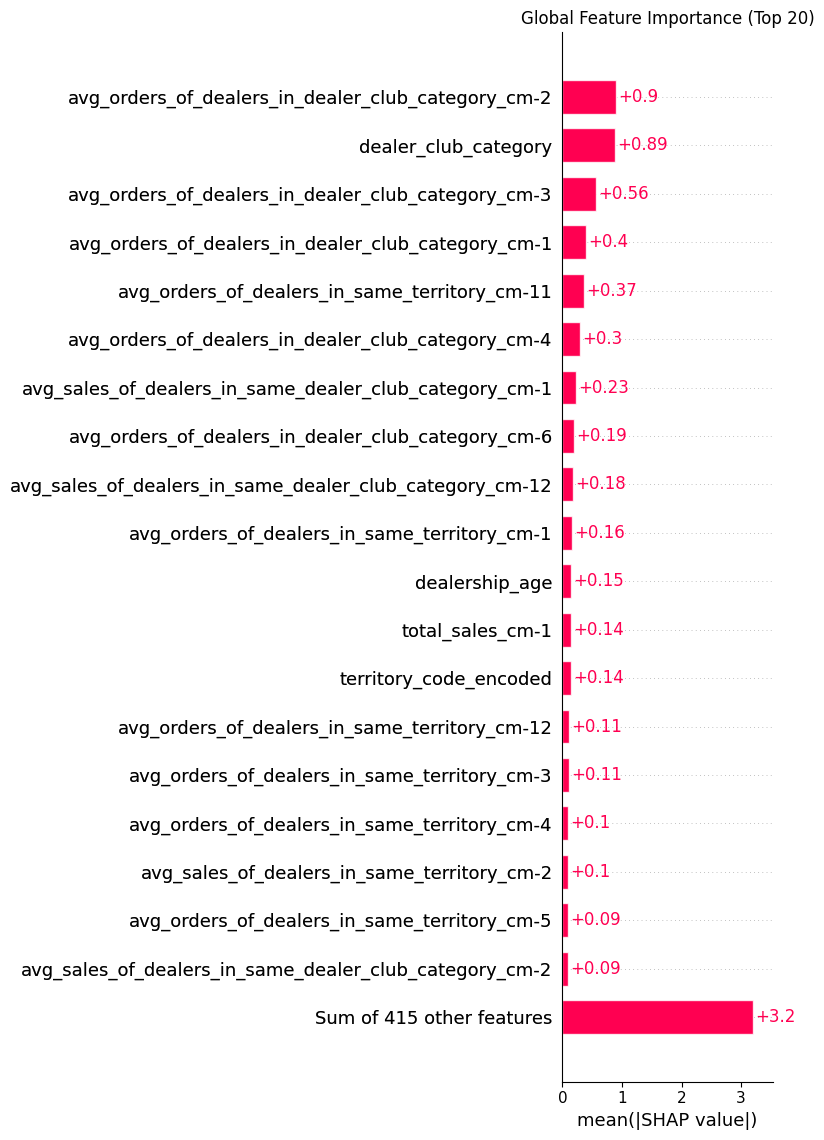

✅ Global importance plot created
📊 Plotting SHAP summary plot (top 20)...


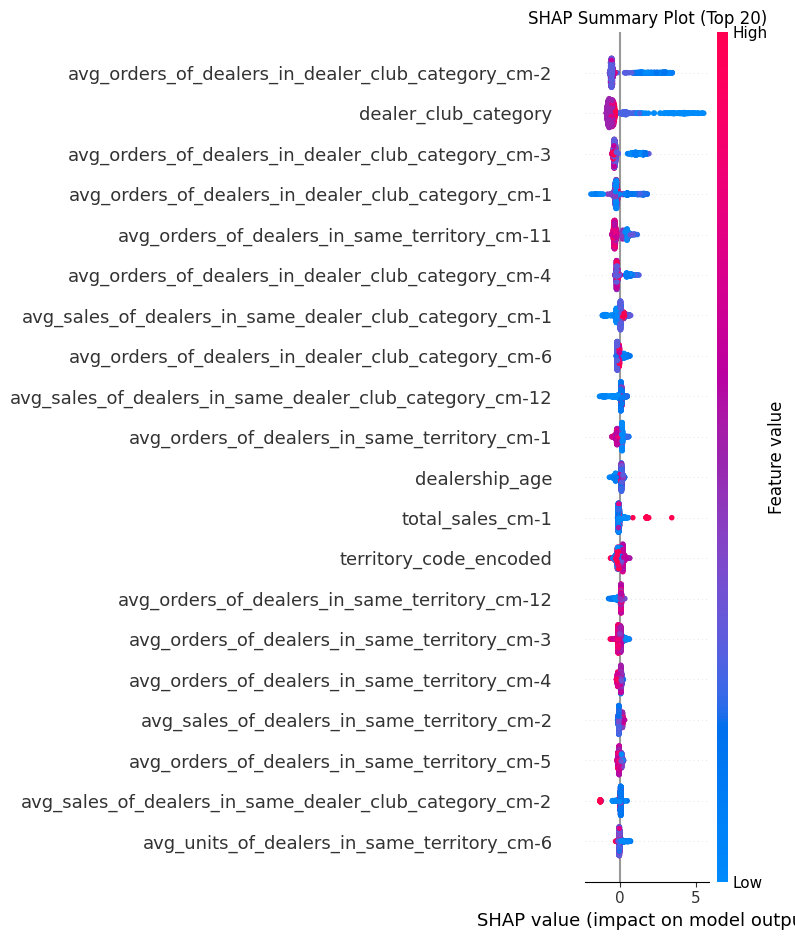

✅ Summary plot created
🔍 Explaining individual prediction for index 0...


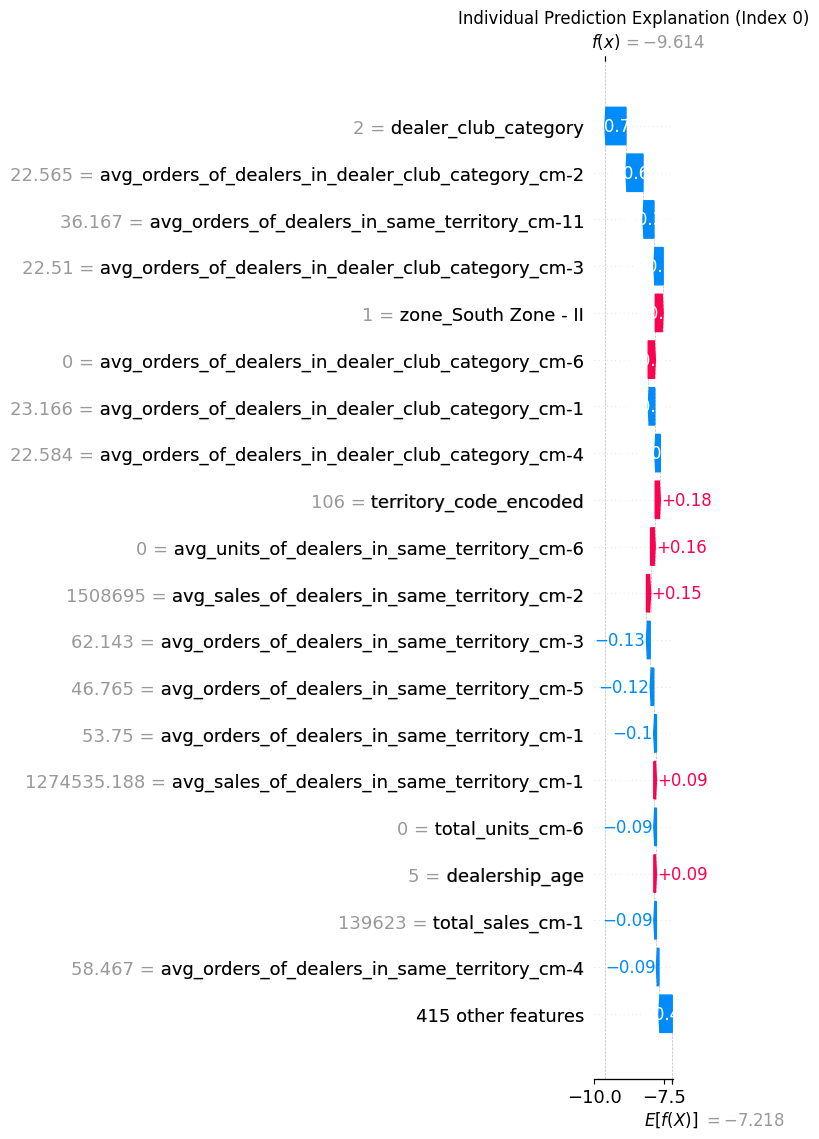

✅ Individual explanation created
🔍 Explaining individual prediction for index 1...


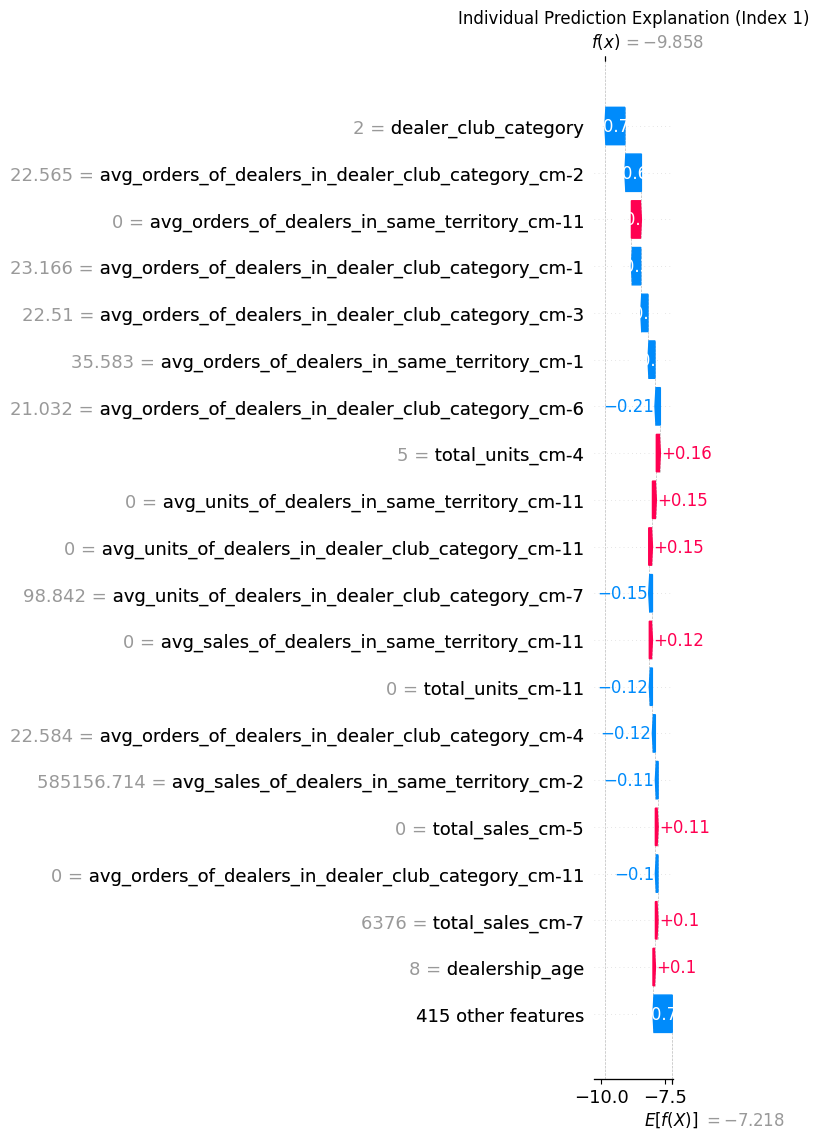

✅ Individual explanation created
🔍 Explaining individual prediction for index 2...


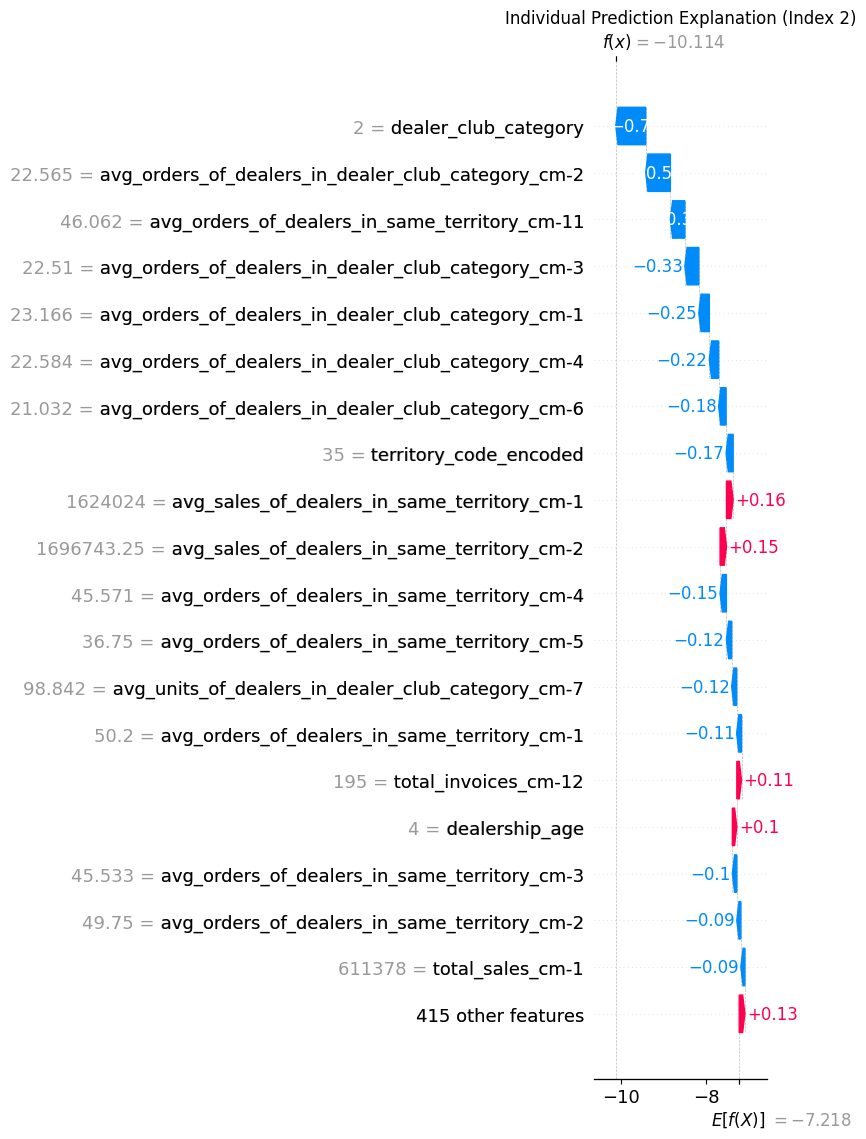

✅ Individual explanation created
🔍 Analyzing top 10 churn drivers...
✅ Top 10 churn drivers identified

🎉 Model explanation completed successfully!

Pipeline Setup [██████████████████████████████] 100.0% (5/5)
   Setting up production predictor
📂 Loading model from models/xgb_churn_model.pkl...
✅ Model loaded successfully!
✅ Preprocessor info loaded

🎉 Complete training pipeline finished successfully!
Model saved to: models/xgb_churn_model.pkl
Feature importance saved to: models/feature_importance.csv


{'preprocessed_data': {'X_train':              total_sales_cm-1  total_sales_cm-10  total_sales_cm-11  \
  dealer_code                                                           
  1121243              947027.0          2045769.0           983602.0   
  1106390              188380.0           338305.0            -5690.0   
  1122847              290850.0                0.0                0.0   
  1120131               26399.0            72082.0             9951.0   
  1121263                4877.0           282991.0            71593.0   
  ...                       ...                ...                ...   
  1118869               19575.0           644755.0           473390.0   
  1111878               36710.0            86340.0           316800.0   
  1116932                6250.0           311423.0           434887.0   
  1118204               83100.0            59790.0                0.0   
  1114194             -200874.0           457568.0           275241.0   
  
               t

In [2]:
model_pipeline.run_complete_training_pipeline()

In [ ]:
prediction_results = model_pipeline.run_production_prediction_pipeline()

🚀 Starting Production Prediction Pipeline
📂 Loading model from models/xgb_churn_model.pkl...
✅ Model loaded successfully!
🚀 Starting prediction for all dealers...
📊 Loading data from offset_features.csv...
🔧 Preparing data for production prediction...
📊 Applying preprocessing steps...
✅ Data prepared. Shape: (6161, 434)
🎯 Making churn predictions...
✅ Predictions completed for 6161 dealers
📋 Creating prediction results...
✅ Prediction results created
💾 Saving predictions to output/predictions.csv...
✅ Predictions saved successfully!

📊 Prediction Summary:
------------------------------
Total Dealers: 6161
Predicted to Churn: 576 (9.35%)
Predicted to Stay Active: 5585 (90.65%)

Risk Category Distribution:
  Low Risk: 5584 (90.63%)
  High Risk: 572 (9.28%)
  Medium Risk: 5 (0.08%)

Churn Probability Statistics:
  Mean: 0.0942
  Median: 0.0000
  Max: 1.0000
  Min: 0.0000

🎉 Prediction completed successfully!

🎉 Production prediction pipeline completed successfully!


,dealer_code,predicted_churn,churn_probability,prediction_label,risk_category,prediction_timestamp
0,1100001,0,0.00000,Active,Low Risk,2025-09-03 18:34:55
1,1100011,0,0.00042,Active,Low Risk,2025-09-03 18:34:55
2,1100014,1,0.99977,Churned,High Risk,2025-09-03 18:34:55
3,1100015,0,0.00000,Active,Low Risk,2025-09-03 18:34:55
4,1100030,0,0.00027,Active,Low Risk,2025-09-03 18:34:55
...,...,...,...,...,...,...
6156,1123159,0,0.00016,Active,Low Risk,2025-09-03 18:34:55
6157,1123160,0,0.00017,Active,Low Risk,2025-09-03 18:34:55
6158,1123161,0,0.00106,Active,Low Risk,2025-09-03 18:34:55
6159,1123162,0,0.00111,Active,Low Risk,2025-09-03 18:34:55


In [ ]:
from dlt_utils import DLTWriter

dlt_writer = DLTWriter(catalog="provisioned-tableau-data", schema="data_science")
file_path = "dealer_churn_predictions"
dlt_writer.write_table(prediction_results, file_path, mode="overwrite")


In [ ]:
# import pandas as pd
# pd.set_option('display.max_columns', None)

In [ ]:
# df_prod = pd.read_csv('offset_features.csv')
# df_ref = pd.read_csv('_offset_features.csv')
